In [1]:
import sys
import os

# Add the parent directory to sys.path to allow imports from src
sys.path.append(os.path.abspath(".."))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
)

from src.data import download_data, build_preprocessor, DiabetesDataset
from src.models import MLPModel, LinearRegressionModel, RandomForestModel
from src.train import train_torch_model

# Download & Load Data

In [2]:
download_data()

Dataset already exists, skipping download.


In [3]:
diabetes_data = pd.read_csv("../data/diabetes/diabetic_data.csv")

# Preprocess Data

In [4]:
diabetes_data.drop(
    ["weight", "payer_code", "medical_specialty", "encounter_id", "patient_nbr"],
    axis=1,
    inplace=True,
)
diabetes_data.drop_duplicates(inplace=True)
diabetes_data["readmitted"] = diabetes_data["readmitted"].apply(
    lambda x: 1 if x == "<30" else 0
)

In [5]:
X = diabetes_data.drop(columns=["readmitted"])
y = diabetes_data["readmitted"]

preprocessor = build_preprocessor()
X_processed = preprocessor.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.15, random_state=21
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1765, random_state=21
)  # 0.1765 x 0.85 = 0.15

y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)
y_val = y_val.values.reshape(-1, 1)

neg, pos = np.bincount(y_train.flatten())
pos_weight = neg / pos


In [6]:
# For pytorch models

batch_size = 32
torch.manual_seed(21)

train_dataset = DiabetesDataset(X_train, y_train)
test_dataset = DiabetesDataset(X_test, y_test)
val_dataset = DiabetesDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Train models

## MLP Model

In [7]:
######### HYPERPARAMETERS #########
mlp_input_dim = X_train.shape[1]
mlp_hidden_dims = [256, 128, 32]
mlp_output_dim = 1

mlp_learning_rate = 1e-4
mlp_num_epochs = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else device)
###################################

mlp_model = MLPModel(
    input_dim=mlp_input_dim,
    hidden_dims=mlp_hidden_dims,
    output_dim=mlp_output_dim,
)
print(mlp_model)

MLPModel(
  (network): Sequential(
    (0): Linear(in_features=2352, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=128, out_features=32, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [8]:
mlp_loss = torch.nn.BCEWithLogitsLoss(
    pos_weight=torch.tensor([pos_weight], dtype=torch.float32).to(device)
)
mlp_optimizer = torch.optim.Adam(mlp_model.parameters(), lr=mlp_learning_rate)

mlp_train_losses, mlp_val_losses = train_torch_model(
    model=mlp_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=mlp_loss,
    optimizer=mlp_optimizer,
    num_epochs=mlp_num_epochs,
    device=device,
)

Epoch 1/10, Loss: 1.2280
Validation Loss: 1.2217
Epoch 2/10, Loss: 1.2003
Validation Loss: 1.1942
Epoch 3/10, Loss: 1.1829
Validation Loss: 1.1845
Epoch 4/10, Loss: 1.1755
Validation Loss: 1.1822
Epoch 5/10, Loss: 1.1713
Validation Loss: 1.1811
Epoch 6/10, Loss: 1.1646
Validation Loss: 1.1773
Epoch 7/10, Loss: 1.1630
Validation Loss: 1.1835
Epoch 8/10, Loss: 1.1568
Validation Loss: 1.1771
Epoch 9/10, Loss: 1.1536
Validation Loss: 1.1784
Epoch 10/10, Loss: 1.1483
Validation Loss: 1.1760


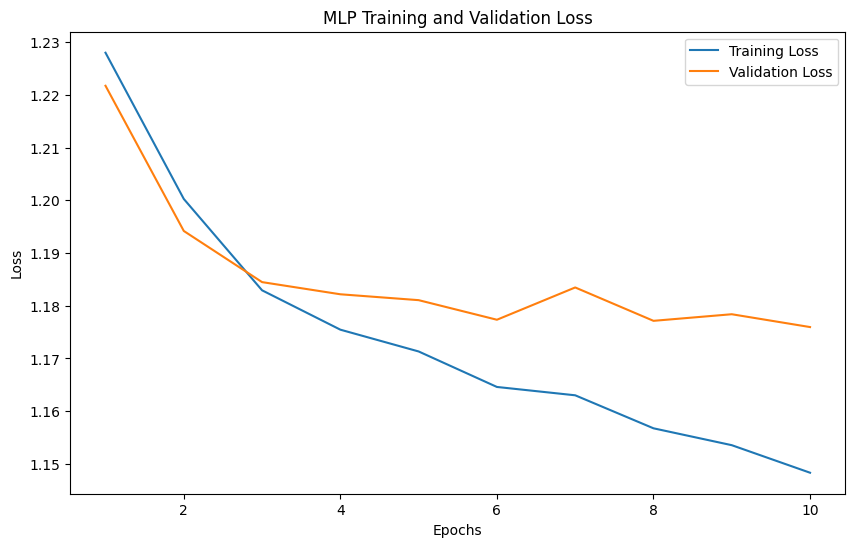

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, mlp_num_epochs + 1), mlp_train_losses, label="Training Loss")
plt.plot(range(1, mlp_num_epochs + 1), mlp_val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("MLP Training and Validation Loss")
plt.legend()
plt.show()

In [10]:
# Obtain predictions on test set for evaluation

mlp_predictions = []
mlp_model.eval()
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = mlp_model(inputs)
        predicted = torch.round(torch.sigmoid(outputs))
        mlp_predictions.extend(predicted.cpu().numpy())

## Linear Regression model

In [13]:
######### HYPERPARAMETERS #########
lr_input_dim = X_train.shape[1]
lr_output_dim = 1

lr_learning_rate = 1e-4
lr_num_epochs = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("mps" if torch.backends.mps.is_available() else device)
###################################

lr_model = LinearRegressionModel(
    input_dim=lr_input_dim,
    output_dim=lr_output_dim,
)
print(lr_model)

LinearRegressionModel(
  (linear): Linear(in_features=2352, out_features=1, bias=True)
)


In [14]:
lr_loss = torch.nn.BCEWithLogitsLoss(
    pos_weight=torch.tensor([pos_weight], dtype=torch.float32).to(device)
)
lr_optimizer = torch.optim.Adam(lr_model.parameters(), lr=lr_learning_rate)

lr_train_losses, lr_val_losses = train_torch_model(
    model=lr_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=lr_loss,
    optimizer=lr_optimizer,
    num_epochs=lr_num_epochs,
    device=device,
)

Epoch 1/10, Loss: 1.2191
Validation Loss: 1.2130
Epoch 2/10, Loss: 1.1875
Validation Loss: 1.1994
Epoch 3/10, Loss: 1.1770
Validation Loss: 1.1937
Epoch 4/10, Loss: 1.1724
Validation Loss: 1.1887
Epoch 5/10, Loss: 1.1691
Validation Loss: 1.1895
Epoch 6/10, Loss: 1.1671
Validation Loss: 1.1868
Epoch 7/10, Loss: 1.1653
Validation Loss: 1.1864
Epoch 8/10, Loss: 1.1636
Validation Loss: 1.1841
Epoch 9/10, Loss: 1.1624
Validation Loss: 1.1842
Epoch 10/10, Loss: 1.1605
Validation Loss: 1.1834


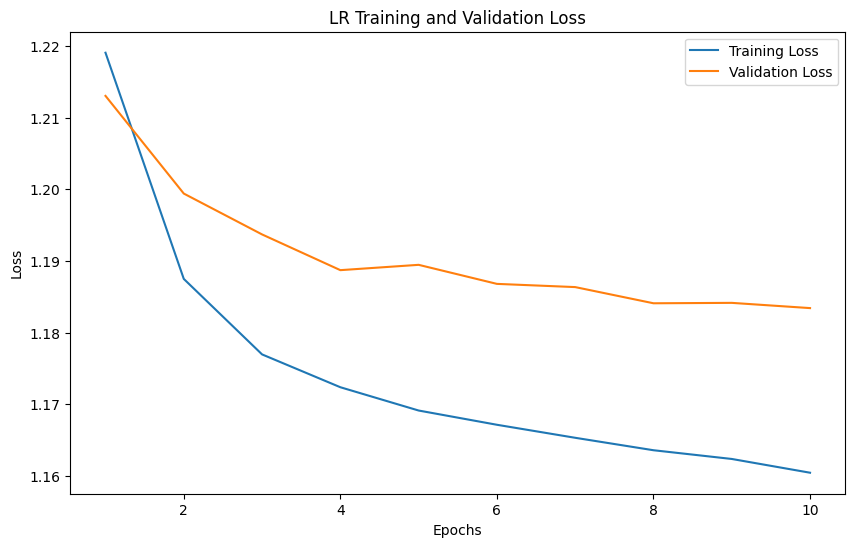

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, lr_num_epochs + 1), lr_train_losses, label="Training Loss")
plt.plot(range(1, lr_num_epochs + 1), lr_val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("LR Training and Validation Loss")
plt.legend()
plt.show()


In [16]:
# Obtain predictions on test set for evaluation

lr_predictions = []
lr_model.eval()
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = lr_model(inputs)
        predicted = torch.round(torch.sigmoid(outputs))
        lr_predictions.extend(predicted.cpu().numpy())


## Random Forest model

In [23]:
######### HYPERPARAMETERS #########
rf_n_estimators = 100
rf_max_depth = None
###################################

rf_model = RandomForestModel(
    n_estimators=rf_n_estimators,
    max_depth=rf_max_depth,
)

print(rf_model.model)

RandomForestClassifier(class_weight='balanced')


In [24]:
rf_model.fit(X_train, y_train.flatten())
rf_predictions = rf_model.predict(X_test)

## XGBoost model

In [27]:
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.3],
    "subsample": [0.8, 1.0],
}

neg, pos = np.bincount(y_train.flatten())
pos_weight = neg / pos


xgb_base = XGBClassifier(
    eval_metric="logloss",
    scale_pos_weight=pos_weight,
    random_state=42,
)

grid_search = GridSearchCV(
    estimator=xgb_base, param_grid=param_grid, scoring="f1", cv=3, verbose=1, n_jobs=-1
)
print(grid_search)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=N

In [28]:
grid_search.fit(X_train, y_train)


xgb_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

xgb_predictions = xgb_model.predict(X_test)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Parameters: {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}


# Evaluate

In [29]:
print("MLP Model Evaluation:")
print("Classification Report:\n", classification_report(y_test, mlp_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, mlp_predictions))

MLP Model Evaluation:
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.58      0.71     13518
           1       0.16      0.64      0.26      1747

    accuracy                           0.58     15265
   macro avg       0.54      0.61      0.49     15265
weighted avg       0.84      0.58      0.66     15265

Confusion Matrix:
 [[7774 5744]
 [ 622 1125]]


In [30]:
print("Linear Regression Model Evaluation:")
print("Classification Report:\n", classification_report(y_test, lr_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, lr_predictions))

Linear Regression Model Evaluation:
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.61      0.73     13518
           1       0.16      0.59      0.26      1747

    accuracy                           0.61     15265
   macro avg       0.54      0.60      0.49     15265
weighted avg       0.83      0.61      0.68     15265

Confusion Matrix:
 [[8246 5272]
 [ 717 1030]]


In [31]:
print("Random Forest Model Evaluation:")
print("Classification Report:\n", classification_report(y_test, rf_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, rf_predictions))

Random Forest Model Evaluation:
Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94     13518
           1       1.00      0.00      0.00      1747

    accuracy                           0.89     15265
   macro avg       0.94      0.50      0.47     15265
weighted avg       0.90      0.89      0.83     15265

Confusion Matrix:
 [[13518     0]
 [ 1745     2]]


In [32]:
print("XGBoost Model Evaluation:")
print("Classification Report:\n", classification_report(y_test, xgb_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, xgb_predictions))

XGBoost Model Evaluation:
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.64      0.76     13518
           1       0.18      0.59      0.27      1747

    accuracy                           0.64     15265
   macro avg       0.55      0.61      0.51     15265
weighted avg       0.84      0.64      0.70     15265

Confusion Matrix:
 [[8704 4814]
 [ 724 1023]]
